In [55]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h = np.transpose(dataset.variables['h'], axes=(1, 0))
f = np.transpose(dataset.variables['f'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [ ]:
## Entire depth range of model

# import numpy as np
# import xarray as xr
# import xroms 

# z_r = np.load('/srv/scratch/z5297792/z_r.npy')          
# z_r = np.transpose(z_r, (1, 2, 0))                    
# dz  = np.diff(z_r, axis=2)                              
# w   = np.abs(dz)                                       

# fnumbers = [f'{num:05}' for num in range(1461, 10611+1, 30)]

# for ii, fnum in enumerate(fnumbers):
#     ds = xr.open_dataset(f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_{fnum}.nc')
#     N2 = ds.xroms.N2.data                              
#     ds.close()

#     N2 = np.transpose(N2, (3, 2, 1, 0))                
#     N2 = np.flip(N2, axis=2)    
#     N2 = N2[:,:,1:-1,:]

#     N  = np.where(N2 > 0, np.sqrt(N2), np.nan)         

#     # broadcast weights (x, y, zmid) across time
#     Nbar = np.nansum(N * w[..., None], axis=2) / np.nansum(w, axis=2)[..., None]  

#     np.save('/srv/scratch/z5297792/Climatology/N2s/Nbar_'+str(fnum)+'.npy', Nbar)

#     if ii % 10 == 0:
#         print(fnum)
        

In [ ]:
import numpy as np
import xarray as xr
import xroms

H = 1000.0  # metres

# rho-level depths
z_r = np.load('/srv/scratch/z5297792/z_r.npy')    # (x, y, zrho)
z_r = np.transpose(z_r, (1, 2, 0))  

dz    = np.diff(z_r, axis=2)                      # (x, y, zmid)
w     = np.abs(dz)

# mask for layers deeper than 300 m
mask = (-z_r[:,:,:-1]) > H
w_masked = w.copy()
w_masked[mask] = np.nan

fnumbers = [f'{num:05}' for num in range(1461, 10611+1, 30)]

for ii, fnum in enumerate(fnumbers):
    ds  = xr.open_dataset(f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_{fnum}.nc')
    N2d = ds.xroms.N2.data                        # (x, y, zmid, t)
    ds.close()

    N2d = np.transpose(N2d, (3, 2, 1, 0))                
    N2d = np.flip(N2d, axis=2)    

    N2d = N2d[:,:,1:-1,:]

    # mask N2 below 300 m
    N2d[mask, :] = np.nan

    # sqrt safely
    N = np.where(N2d > 0, np.sqrt(np.maximum(N2d, 0)), np.nan)

    # depth-weighted mean over top 300 m
    Nbar = np.nansum(N * w_masked[..., None], axis=2) / np.nansum(w_masked, axis=2)[..., None]  # (x, y, t)

    np.save(f'/srv/scratch/z5297792/Climatology/N2s/N2s_300m_depth/Nbar_{fnum}.npy', Nbar.astype('float32'))
    if ii % 10 == 0:
        print(fnum)


01461


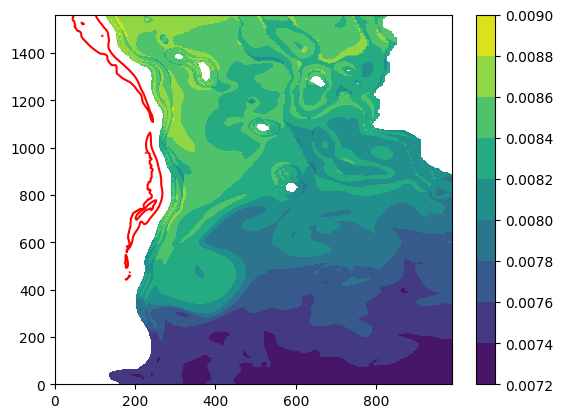

In [69]:
plt.contourf(X_grid, Y_grid, np.where(h > 2000, Nbar[:,:,0], np.nan))
plt.colorbar()
plt.contour(X_grid, Y_grid, Nbar[:,:,0], levels=[.0125], colors='r')



In [11]:
Nbar.shape

(272, 317, 30)